#### In this tutorial non-Convex DistFlow, Convex DistFlow model and non-convex BIM will be compared. Gurobi solver is used for the convex problem while IPOPT is used for the non-Convex problems. 7-bus System is used as a test case.

In [1]:
##################----------------- Import Libraries -------------########################

from pyomo.environ import *
from pyomo.opt import SolverFactory
import math
import os
import numpy as np
import pandas as pd
import pandapower as pp
import pandapower.pf as pf
from pandapower import networks
import pandapower.plotting as plot
import pandapower.networks as pn
import matplotlib.pyplot as plt
import random
from scipy import stats
from scipy.stats import t
import sys
current_directory = os.getcwd()

In [2]:
# For auto reload libraries without the need to restart kernel
############# USE ONLY IN DEVELOPING MODE FOR EASIER MODIFICAITON IN LIBRARIES ##############
%load_ext autoreload
%autoreload 2

### This is the BIM formulation and run

In [ ]:
%run ../Data/networks/three_feeders_Strovolides_Network.ipynb
# %run ../Data/networks/7-Bus-Test-System.ipynb

#######################------------------- Easy method to get the admittance Matrix ----------------####################33
# Run a power flow calculation

pp.runpp(net)

# Access the Y-bus matrix from the network results
Ybus = net["_ppc"]["internal"]["Ybus"]
# print("Y-bus matrix:\n", Ybus.todense())

# Convert the sparse Y-bus matrix to a dense format and then to a DataFrame
Y_bus_df = pd.DataFrame(Ybus.todense())

# Add row and column labels if needed
Y_bus_df.index = net.bus.index
Y_bus_df.columns = net.bus.index
# print(Y_bus_df)
################### OR ######################

Ybus = build_ybus(net)

### Generate load/DER time scale data
file_path2 = '../Data/profiles/pv_load_profiles/Profiles_for_testing.xlsx'
profiles = pd.read_excel(file_path2)
profiles = pd.concat([profiles]*2, ignore_index=True)

In [17]:
############## Initialize model ######################

sys.path.append('../v8_Main/src')

from Manager import *
manager = Manager(net=net)
manager.addTime(timeframe=48,time_interval=30) ## At objective, timeframe(in hours) , time-interval(in minutes)
manager.anc_Vars.System_Data_DER.loc[0,'Controllable']=True


In [53]:
# Custom Add EVs since in pandapower EVs are not available

manager.anc_Vars.addEV(node=3,P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=30, EV_SoC_end=100, EV_SoC_min=30, EV_SoC_max=80, EV_cons=17,arrival=[36,36+48],departure=[3,3+48],distance=[20,20])
manager.anc_Vars.addEV(node=4,P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=55, EV_SoC_end=100, EV_SoC_min=25, EV_SoC_max=80, EV_cons=16,arrival=[33,33+48],departure=[14,14+48],distance=[50,50])
manager.anc_Vars.addEV(node=5,P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=50, EV_SoC_end=100, EV_SoC_min=30, EV_SoC_max=80, EV_cons=18,arrival=[31,31+48],departure=[17,17+48],distance=[15,15])
manager.anc_Vars.addEV(node=6,P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=57, EV_SoC_end=100, EV_SoC_min=35, EV_SoC_max=80, EV_cons=17,arrival=[31,31+48],departure=[13,13+48],distance=[1,1])

# print(manager.anc_Vars.system_data_ev)
# print(manager.anc_Vars.system_data_ev_char)


In [54]:
# This code initialize/create all the needed sets in pyomo model.
manager.initialize_sets()  # Initialize sets

print(manager.list_sets())
# manager.show_set("Sbuses")
# manager.show_set("SGrid")
# manager.show_set("SDER_contr")
# manager.show_set("SDER_uncontr")
# manager.show_set("SLoadbuses")
# manager.show_set("Slines")
# manager.show_set("STimes")
# manager.show_set("SEVbuses")
# manager.show_set("SDistance_ind")

['Sbuses', 'SGrid', 'SDER_contr', 'SDER_uncontr', 'SLoadbuses', 'Slines', 'STimes', 'SEVbuses', 'SDistance_ind', 'Sdownstream', 'Supstream']


In [55]:
############################---------------------- Define Parameters ---------------------############################

# Why defined parameters? if we defined parameters instead of using for example panda dataframe then we can rerun the model without the need to 
# rebuild the constraints during the solving it automatically get the new parameters so the steps for a load modification example is the following
# 1) Define the load profile dataframe, 2) Run variables 3) Run parameters, 4)Build model, 5) Solve optimization, 6)Change load profile , 7) Run parameters ,8) Solve optimization
# MUTABLE=TRUE is the function parameter that allow this

manager.load_profile_param(profiles, "Load_P", "Load_Q") # This create Load_P and Load_Q profile which is equal to PandapowerPower*p.u. [from profiles files]
manager.line_param(Y_bus_df, "resistance_Parm", "reactance_Parm", "admitt_mat_Parm_real", "admitt_mat_Parm_imag")

############ EV #################
manager.initialize_ev_params("ev_min_ch_param", "ev_max_ch_param", "EVinit_SOC", "EVend_SOC_param", "EV_SoC_min_param", "EV_SoC_max_param", "EV_capacity_param")
manager.initialize_ev_char_params("ev_arrival_time_param", "ev_departure_time_param", "ev_trip_distance_param", "EV_SoC_min_departure_param",  "EV_trip_energy_needs_param", "EV_available_param" )
manager.initialize_ev_min_soc_timeseries("EV_SoC_min_overtime_param")

############ DER #################
manager.der_profile_param(profiles, "unctrl_PV_gen_P", "unctrl_PV_gen_Q", "ctrl_PV_gen_P", "ctrl_PV_gen_Q")

print(manager.list_parameters())
manager.show_parameter("Load_P")

['Load_P', 'Load_Q', 'resistance_Parm', 'reactance_Parm', 'admitt_mat_Parm_real', 'admitt_mat_Parm_imag', 'ev_min_ch_param', 'ev_max_ch_param', 'EVinit_SOC', 'EVend_SOC_param', 'EV_SoC_min_param', 'EV_SoC_max_param', 'EV_capacity_param', 'ev_arrival_time_param', 'ev_departure_time_param', 'ev_trip_distance_param', 'EV_SoC_min_departure_param', 'EV_trip_energy_needs_param', 'EV_available_param', 'EV_SoC_min_overtime_param', 'unctrl_PV_gen_P', 'ctrl_PV_gen_P', 'unctrl_PV_gen_Q', 'ctrl_PV_gen_Q']
Variable Load_P:
  (1, 0): 0.007778337437460318
  (1, 1): 0.007548256571428571
  (1, 2): 0.007402299058412698
  (1, 3): 0.007253581271746031
  (1, 4): 0.007061102495238095
  (1, 5): 0.006771032133333334
  (1, 6): 0.0064615987580952374
  (1, 7): 0.006213990239365078
  (1, 8): 0.005917003424126984
  (1, 9): 0.005540396665396825
  (1, 10): 0.005515541570793651
  (1, 11): 0.005258671019047618
  (1, 12): 0.005241968411428571
  (1, 13): 0.005341841427301586
  (1, 14): 0.005375855011428571
  (1, 15): 0.

In [56]:
############################---------------------- Define Variables ---------------------############################

# ###################### Normal Operation Scenario ########################
manager.initialize_voltage_variables("v", "pa")
manager.initialize_power_variable("pgrid", manager.model.SGrid)
manager.initialize_power_variable("qgrid", manager.model.SGrid)
manager.initialize_der_variables("pder_contr", "pder_curtail_contr", "qder_contr")
manager.initialize_line_variables("Line_curr", "Line_rea_curr", "Line_act_curr", "Line_losses")

ref_bus=0 # THIS MUST BE ADDED AUTOMATICALLY 
for t in manager.model.STimes:
    manager.model.v[ref_bus, t].fix(1)
    manager.model.pa[ref_bus, t].fix(0)

###################### EV Variables ########################

manager.initialize_ev_variables("pEVch","qEV", "EVsoc")

print(manager.list_variables())

['v', 'pa', 'pgrid', 'qgrid', 'pder_contr', 'pder_curtail_contr', 'qder_contr', 'Line_curr', 'Line_rea_curr', 'Line_act_curr', 'Line_losses', 'pEVch', 'qEV', 'EVsoc']


In [57]:
########### Line Flow constraints ########################

manager.add_real_line_flow_constraint("real_line_flow", manager.model.Line_act_curr, manager.model.v, manager.model.pa)
manager.add_reactive_line_flow_constraint("reactive_line_flow", manager.model.Line_rea_curr, manager.model.v, manager.model.pa)
manager.add_line_flow_constraint("line_flow", manager.model.Line_curr, manager.model.Line_act_curr, manager.model.Line_rea_curr)
manager.add_line_flow_losses_constraint(manager.model.Line_curr, "line_losses")

###################-----------------Curtail DER Power Constrain ------------#######################

def Curtail_DER_Power_rule(model, i, time):
    return (model.pder_curtail_contr[i,time] ==  model.pder_curtail_contr[i,  time].ub - model.pder_contr[i,  time])
manager.model.Curtail_DER_cons = Constraint(manager.model.SDER_contr,manager.model.STimes, rule=Curtail_DER_Power_rule)  # Minimum, Maximum power for Gen

####################-------------------- EV Constrain -----------------------#######################
manager.add_ev_soc_constraint("EV_SOC_cons")
# Fix variables for non-charging times
manager.fix_ev_non_charging_times(model_ev_ch=manager.model.pEVch, model_ev_flex_up=None, model_ev_flex_down=None)

####################-------------------- Power Flow Constrain -----------------------#######################

manager.add_active_power_flow_constraint(manager.model.pder_contr, manager.model.pgrid, manager.model.pEVch, manager.model.v, manager.model.pa, "active_power_flow")
manager.add_reactive_power_flow_constraint(manager.model.qder_contr, manager.model.qgrid, manager.model.qEV, manager.model.v, manager.model.pa, "reactive_power_flow")

In [58]:
####################-------------------- Objective -----------------------#######################

def obj_rule(model):

    losses_term = sum(model.Line_losses[sfrom, sto, time]
                      for time in model.STimes 
                      for sfrom, sto in model.Slines)

    curtail_term = 300*sum(model.pder_curtail_contr[der, time]
                       for der in model.SDER_contr
                       for time in model.STimes)
    
    return losses_term + curtail_term

manager.model.obj = Objective(rule=obj_rule, sense=minimize)


In [59]:
# Define the solver without syntax issues and include line breaks
solver = SolverFactory('ipopt')

solver.options['max_iter'] = 5000  # Increase the maximum number of iterations
solver.options['tol'] = 1e-10       # Set a smaller tolerance for convergence
solver.options['print_level'] = 5  # Higher levels provide more detailed output (0-12)
# solver.options['acceptable_tol'] = 1e-4            # early stopping
# solver.options['output_file'] = 'ipopt_log.txt'  # Save IPOPT log to a file

results = solver.solve(manager.model, tee=True)

# After solving, print the results
print("Status: ", results.solver.status)
print("Termination Condition: ", results.solver.termination_condition)

# Check if the solution is feasible
if results.solver.termination_condition == TerminationCondition.optimal:
    
    print("successful")
    # Extract solver timing (wallclock time)
    solver_time = results.solver.time  # Total solving time in seconds
    print(f"Solver Time: {solver_time} seconds")

else:
    print("Infeasible solution.")

Ipopt 3.14.17: max_iter=5000
tol=1e-10
print_level=5


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:   157796
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    57408

Total number of variables............................:    36432
                     variables with only lower bounds:     5856
                variables with lower and upper bounds:    18672
                     variables with only upper bounds:        0
Total number of equality constraints..

In [60]:
print("Objective value:", value(manager.model.obj))

manager.results.wrapper_var_results()
print(manager.results.list())
print(manager.results.EVsoc.head())

Objective value: 0.19795240995874006
['EVsoc', 'Line_act_curr', 'Line_curr', 'Line_losses', 'Line_rea_curr', 'pEVch', 'pa', 'pder_contr', 'pder_curtail_contr', 'pgrid', 'qEV', 'qder_contr', 'qgrid', 'v']
          3         4         5         6
0  0.056360  0.097778  0.088889  0.101333
1  0.060039  0.097778  0.088889  0.101333
2  0.064133  0.097778  0.088889  0.101333
3  0.064133  0.097778  0.088889  0.101333
4  0.064133  0.097778  0.088889  0.101333


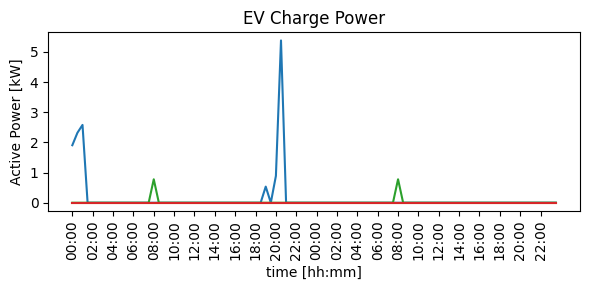

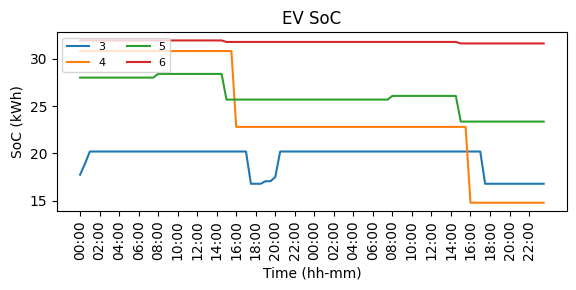

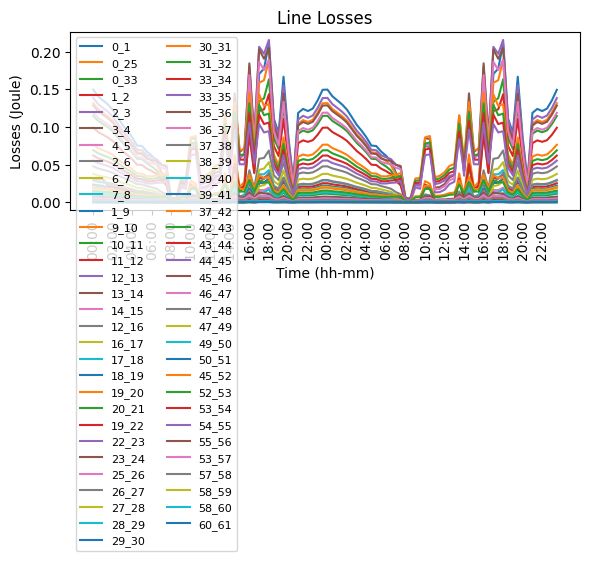

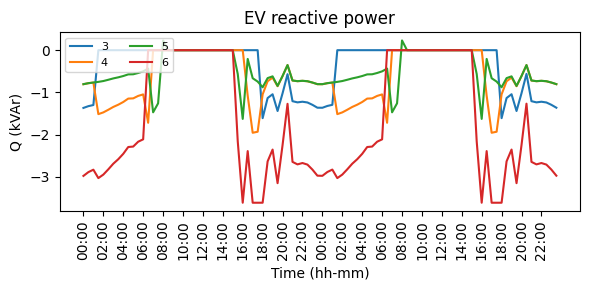

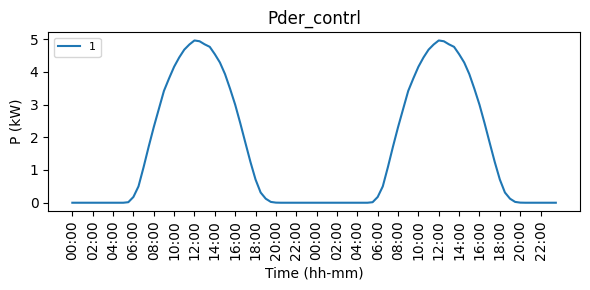

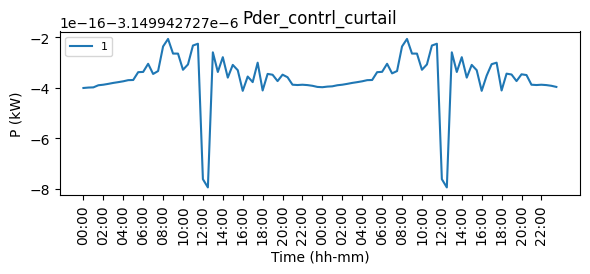

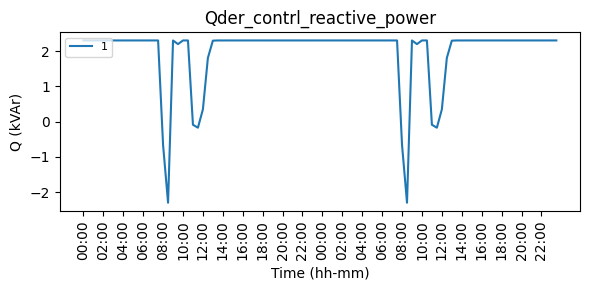

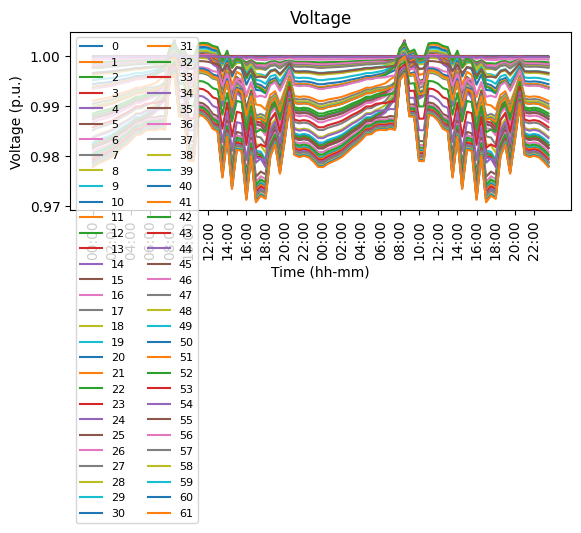

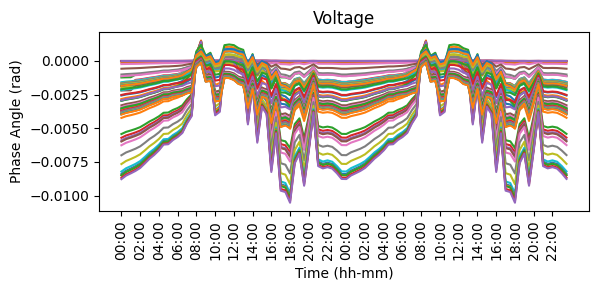

In [61]:
manager.plot_fun.result_df_plot(manager.results.pEVch*manager.anc_Vars.S_Base*1000,"EV Charge Power", "time [hh:mm]" ,"Active Power [kW]")
manager.plot_fun.result_df_plot(manager.results.EVsoc*manager.anc_Vars.S_Base*1000,"EV SoC", "Time (hh-mm)" ,"SoC (kWh)",label="Yes")
manager.plot_fun.result_df_plot(manager.results.Line_losses*manager.anc_Vars.I_base*1000,"Line Losses", "Time (hh-mm)" ,"Losses (Joule)",label="Yes")
manager.plot_fun.result_df_plot(manager.results.qEV*manager.anc_Vars.S_Base*1000,"EV reactive power", "Time (hh-mm)" ,"Q (kVAr)",label="Yes")
manager.plot_fun.result_df_plot(manager.results.pder_contr*manager.anc_Vars.S_Base*1000,"Pder_contrl", "Time (hh-mm)" ,"P (kW)",label="Yes")
manager.plot_fun.result_df_plot(manager.results.pder_curtail_contr*manager.anc_Vars.S_Base*1000,"Pder_contrl_curtail", "Time (hh-mm)" ,"P (kW)",label="Yes")
manager.plot_fun.result_df_plot(manager.results.qder_contr*manager.anc_Vars.S_Base*1000,"Qder_contrl_reactive_power", "Time (hh-mm)" ,"Q (kVAr)",label="Yes")
manager.plot_fun.result_df_plot(manager.results.v,"Voltage", "Time (hh-mm)" ,"Voltage (p.u.)", label="Yes")
manager.plot_fun.result_df_plot(manager.results.pa,"Voltage", "Time (hh-mm)" ,"Phase Angle (rad)")



### Here the BFM [DISTFLOW] is been formulated and executed again with IPOPT since it was not convex

In [63]:
%run ../Data/networks/three_feeders_Strovolides_Network.ipynb
# %run ../Data/networks/7-Bus-Test-System.ipynb

#######################------------------- Easy method to get the admittance Matrix ----------------####################33
# Run a power flow calculation

pp.runpp(net)

# Access the Y-bus matrix from the network results
Ybus = net["_ppc"]["internal"]["Ybus"]
# print("Y-bus matrix:\n", Ybus.todense())

# Convert the sparse Y-bus matrix to a dense format and then to a DataFrame
Y_bus_df = pd.DataFrame(Ybus.todense())

# Add row and column labels if needed
Y_bus_df.index = net.bus.index
Y_bus_df.columns = net.bus.index

# print(Y_bus_df)

### Generate load/DER time scale data
file_path2 = '../Data/profiles/pv_load_profiles/Profiles_for_testing.xlsx'
profiles = pd.read_excel(file_path2)
profiles = pd.concat([profiles]*2, ignore_index=True)

In [64]:
sys.path.append('../v8_Main/src')

from Manager import *
manager = Manager(net=net)
manager.addTime(timeframe=48,time_interval=30) ## At objective, timeframe(in hours) , time-interval(in minutes)
manager.anc_Vars.System_Data_DER.loc[0,'Controllable']=True

In [65]:
# Custom Add EVs since in pandapower EVs are not available

manager.anc_Vars.addEV(node=3,P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=30, EV_SoC_end=100, EV_SoC_min=30, EV_SoC_max=80, EV_cons=17,arrival=[36,36+48],departure=[3,3+48],distance=[20,20])
manager.anc_Vars.addEV(node=4,P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=55, EV_SoC_end=100, EV_SoC_min=25, EV_SoC_max=80, EV_cons=16,arrival=[33,33+48],departure=[14,14+48],distance=[50,50])
manager.anc_Vars.addEV(node=5,P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=50, EV_SoC_end=100, EV_SoC_min=30, EV_SoC_max=80, EV_cons=18,arrival=[31,31+48],departure=[17,17+48],distance=[15,15])
manager.anc_Vars.addEV(node=6,P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=57, EV_SoC_end=100, EV_SoC_min=35, EV_SoC_max=80, EV_cons=17,arrival=[31,31+48],departure=[13,13+48],distance=[1,1])

# print(manager.anc_Vars.system_data_ev)
# print(manager.anc_Vars.system_data_ev_char)


In [66]:
# This code initialize/create all the needed sets in pyomo model.
manager.initialize_sets()  # Initialize sets

print(manager.list_sets())
# manager.show_set("Sbuses")
# manager.show_set("SGrid")
# manager.show_set("SDER_contr")
# manager.show_set("SDER_uncontr")
# manager.show_set("SLoadbuses")
# manager.show_set("Slines")
# manager.show_set("STimes")
# manager.show_set("SEVbuses")
# manager.show_set("SDistance_ind")

['Sbuses', 'SGrid', 'SDER_contr', 'SDER_uncontr', 'SLoadbuses', 'Slines', 'STimes', 'SEVbuses', 'SDistance_ind', 'Sdownstream', 'Supstream']


In [67]:
############################---------------------- Define Parameters ---------------------############################

# Why defined parameters? if we defined parameters instead of using for example panda dataframe then we can rerun the model without the need to 
# rebuild the constraints during the solving it automatically get the new parameters so the steps for a load modification example is the following
# 1) Define the load profile dataframe, 2) Run variables 3) Run parameters, 4)Build model, 5) Solve optimization, 6)Change load profile , 7) Run parameters ,8) Solve optimization
# MUTABLE=TRUE is the function parameter that allow this

manager.load_profile_param(profiles, "Load_P", "Load_Q") # This create Load_P and Load_Q profile which is equal to PandapowerPower*p.u. [from profiles files]
manager.line_param(Y_bus_df, "resistance_Parm", "reactance_Parm", "admitt_mat_Parm_real", "admitt_mat_Parm_imag")

############ EV #################
manager.initialize_ev_params("ev_min_ch_param", "ev_max_ch_param", "EVinit_SOC", "EVend_SOC_param", "EV_SoC_min_param", "EV_SoC_max_param", "EV_capacity_param")
manager.initialize_ev_char_params("ev_arrival_time_param", "ev_departure_time_param", "ev_trip_distance_param", "EV_SoC_min_departure_param",  "EV_trip_energy_needs_param", "EV_available_param" )
manager.initialize_ev_min_soc_timeseries("EV_SoC_min_overtime_param")

############ DER #################
manager.der_profile_param(profiles, "unctrl_PV_gen_P", "unctrl_PV_gen_Q", "ctrl_PV_gen_P", "ctrl_PV_gen_Q")

print(manager.list_parameters())
manager.show_parameter("Load_P")

['Load_P', 'Load_Q', 'resistance_Parm', 'reactance_Parm', 'admitt_mat_Parm_real', 'admitt_mat_Parm_imag', 'ev_min_ch_param', 'ev_max_ch_param', 'EVinit_SOC', 'EVend_SOC_param', 'EV_SoC_min_param', 'EV_SoC_max_param', 'EV_capacity_param', 'ev_arrival_time_param', 'ev_departure_time_param', 'ev_trip_distance_param', 'EV_SoC_min_departure_param', 'EV_trip_energy_needs_param', 'EV_available_param', 'EV_SoC_min_overtime_param', 'unctrl_PV_gen_P', 'ctrl_PV_gen_P', 'unctrl_PV_gen_Q', 'ctrl_PV_gen_Q']
Variable Load_P:
  (1, 0): 0.007778337437460318
  (1, 1): 0.007548256571428571
  (1, 2): 0.007402299058412698
  (1, 3): 0.007253581271746031
  (1, 4): 0.007061102495238095
  (1, 5): 0.006771032133333334
  (1, 6): 0.0064615987580952374
  (1, 7): 0.006213990239365078
  (1, 8): 0.005917003424126984
  (1, 9): 0.005540396665396825
  (1, 10): 0.005515541570793651
  (1, 11): 0.005258671019047618
  (1, 12): 0.005241968411428571
  (1, 13): 0.005341841427301586
  (1, 14): 0.005375855011428571
  (1, 15): 0.

In [68]:
############################---------------------- Define Variables ---------------------############################

# ###################### Normal Operation Scenario ########################
manager.initialize_voltage_square_variables(voltage_name_prefix="v")
manager.initialize_power_variable("pgrid", manager.model.SGrid)
manager.initialize_power_variable("qgrid", manager.model.SGrid)
manager.initialize_power_variable("pline", manager.model.Slines)
manager.initialize_power_variable("qline", manager.model.Slines)
manager.initialize_der_variables("pder_contr", "pder_curtail_contr", "qder_contr")
manager.initialize_line_square_variables(line_curr_name_prefix="Line_curr")
manager.initialize_line_variables(line_losses_name_prefix = "Line_losses")

ref_bus=0 # THIS MUST BE ADDED AUTOMATICALLY 
for t in manager.model.STimes:
    manager.model.v[ref_bus, t].fix(1)

###################### EV Variables ########################
manager.initialize_ev_variables("pEVch","qEV", "EVsoc")

print(manager.list_variables())

['v', 'pgrid', 'qgrid', 'pline', 'qline', 'pder_contr', 'pder_curtail_contr', 'qder_contr', 'Line_curr', 'Line_losses', 'pEVch', 'qEV', 'EVsoc']


In [69]:
########### Line Flow constraints ########################

manager.add_line_flow_amplitude_losses_constraint(manager.model.Line_curr, "line_losses")

###################-----------------Curtail DER Power Constrain ------------#######################

def Curtail_DER_Power_rule(model, i, time):
    return (model.pder_curtail_contr[i,time] ==  model.pder_curtail_contr[i,  time].ub - model.pder_contr[i,  time])
manager.model.Curtail_DER_cons = Constraint(manager.model.SDER_contr,manager.model.STimes, rule=Curtail_DER_Power_rule)  # Minimum, Maximum power for Gen

####################-------------------- EV Constrain -----------------------#######################
manager.add_ev_soc_constraint("EV_SOC_cons")
# Fix variables for non-charging times
manager.fix_ev_non_charging_times(model_ev_ch=manager.model.pEVch, model_ev_flex_up=None, model_ev_flex_down=None)


In [70]:
###################-------------------- Power Flow Constrain -----------------------#######################

manager.add_active_power_flow_df_wos_constraint(manager.model.pder_contr, manager.model.pline, manager.model.pgrid, manager.model.pEVch, manager.model.Line_curr, "active_power_flow")
manager.add_reactive_power_flow_df_wos_constraint(manager.model.qder_contr, manager.model.qline, manager.model.qgrid, manager.model.qEV, manager.model.Line_curr, "reactive_power_flow")
manager.add_voltage_power_flow_df_wos_constraint(manager.model.pline, manager.model.qline, manager.model.Line_curr, manager.model.v,"voltage_pf" )
manager.add_brunch_current_flow_df_wos_equal_constraint(manager.model.pline, manager.model.qline, manager.model.Line_curr, manager.model.v,"current_equal_pf" )

In [71]:
####################-------------------- Objective -----------------------#######################

def obj_rule(model):

    losses_term = sum(model.Line_losses[sfrom, sto, time]
                      for time in model.STimes 
                      for sfrom, sto in model.Slines)

    curtail_term = 300*sum(model.pder_curtail_contr[der, time]
                       for der in model.SDER_contr
                       for time in model.STimes)
    
    return losses_term + curtail_term

manager.model.obj = Objective(rule=obj_rule, sense=minimize)


In [72]:
# Define the solver without syntax issues and include line breaks
solver = SolverFactory('ipopt')

solver.options['max_iter'] = 5000  # Increase the maximum number of iterations
solver.options['tol'] = 1e-10       # Set a smaller tolerance for convergence
solver.options['print_level'] = 5  # Higher levels provide more detailed output (0-12)
solver.options['acceptable_tol'] = 1e-2            # early stopping
# solver.options['output_file'] = 'ipopt_log.txt'  # Save IPOPT log to a file

results = solver.solve(manager.model, tee=True)

# After solving, print the results
print("Status: ", results.solver.status)
print("Termination Condition: ", results.solver.termination_condition)

# Check if the solution is feasible
if results.solver.termination_condition == TerminationCondition.optimal:
    
    print("successful")
    # Extract solver timing (wallclock time)
    solver_time = results.solver.time  # Total solving time in seconds
    print(f"Solver Time: {solver_time} seconds")

else:
    print("Infeasible solution.")

Ipopt 3.14.17: max_iter=5000
tol=1e-10
print_level=5
acceptable_tol=0.01


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:   100964
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    17280

Total number of variables............................:    30576
                     variables with only lower bounds:     5856
                variables with lower and upper bounds:    12816
                     variables with only upper bounds:        0
Total number of eq

In [73]:
print("Objective value:", value(manager.model.obj))

manager.results.wrapper_var_results()
print(manager.results.list())
print(manager.results.EVsoc.head())

Objective value: 0.19795240995880592
['EVsoc', 'Line_curr', 'Line_losses', 'pEVch', 'pder_contr', 'pder_curtail_contr', 'pgrid', 'pline', 'qEV', 'qder_contr', 'qgrid', 'qline', 'v']
          3         4         5         6
0  0.056360  0.097778  0.088889  0.101333
1  0.060039  0.097778  0.088889  0.101333
2  0.064133  0.097778  0.088889  0.101333
3  0.064133  0.097778  0.088889  0.101333
4  0.064133  0.097778  0.088889  0.101333


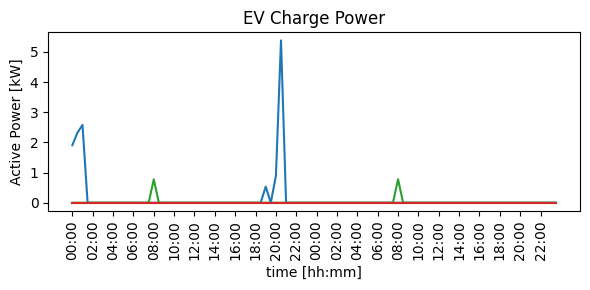

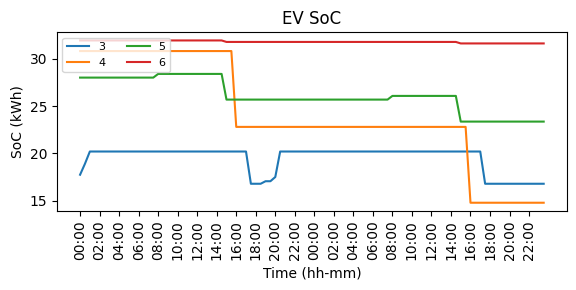

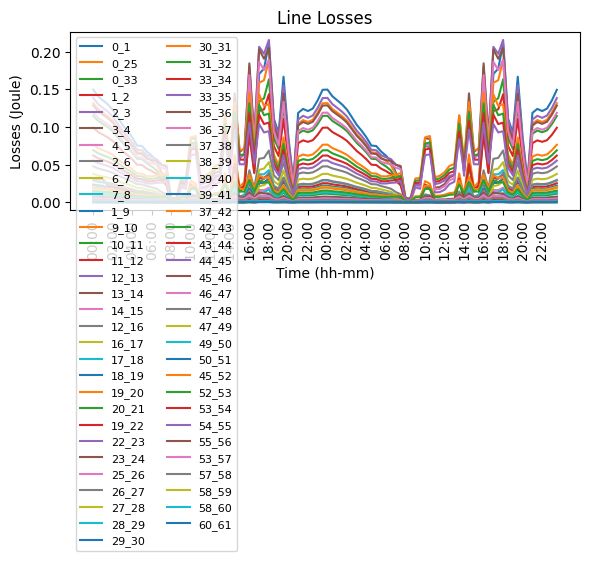

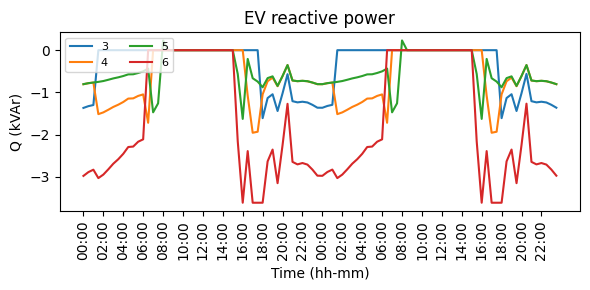

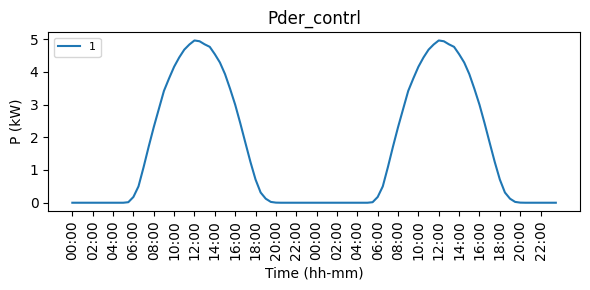

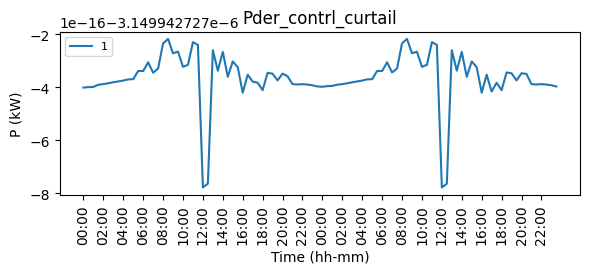

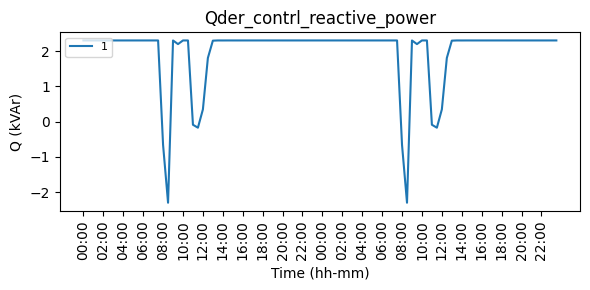

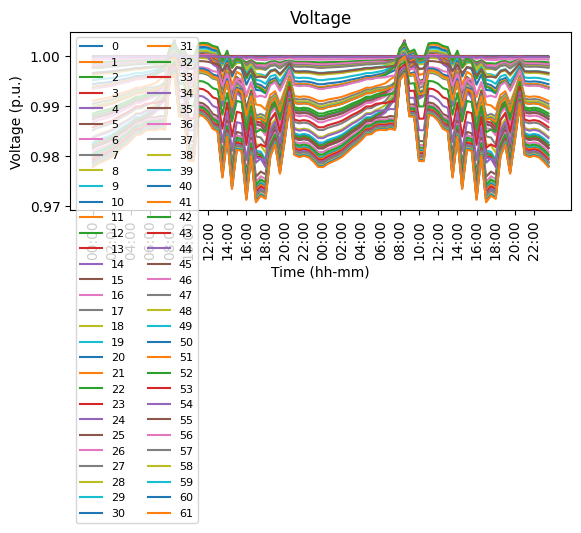

In [74]:
manager.plot_fun.result_df_plot(manager.results.pEVch*manager.anc_Vars.S_Base*1000,"EV Charge Power", "time [hh:mm]" ,"Active Power [kW]")
manager.plot_fun.result_df_plot(manager.results.EVsoc*manager.anc_Vars.S_Base*1000,"EV SoC", "Time (hh-mm)" ,"SoC (kWh)",label="Yes")
manager.plot_fun.result_df_plot(manager.results.Line_losses*manager.anc_Vars.I_base*1000,"Line Losses", "Time (hh-mm)" ,"Losses (Joule)",label="Yes")
manager.plot_fun.result_df_plot(manager.results.qEV*manager.anc_Vars.S_Base*1000,"EV reactive power", "Time (hh-mm)" ,"Q (kVAr)",label="Yes")
manager.plot_fun.result_df_plot(manager.results.pder_contr*manager.anc_Vars.S_Base*1000,"Pder_contrl", "Time (hh-mm)" ,"P (kW)",label="Yes")
manager.plot_fun.result_df_plot(manager.results.pder_curtail_contr*manager.anc_Vars.S_Base*1000,"Pder_contrl_curtail", "Time (hh-mm)" ,"P (kW)",label="Yes")
manager.plot_fun.result_df_plot(manager.results.qder_contr*manager.anc_Vars.S_Base*1000,"Qder_contrl_reactive_power", "Time (hh-mm)" ,"Q (kVAr)",label="Yes")
manager.plot_fun.result_df_plot(np.sqrt(manager.results.v),"Voltage", "Time (hh-mm)" ,"Voltage (p.u.)", label="Yes")


### This is the same DistFlow Model but with SOCP relaxation and solve using GUROBI

In [75]:
%run ../Data/networks/three_feeders_Strovolides_Network.ipynb
# %run ../Data/networks/7-Bus-Test-System.ipynb

#######################------------------- Easy method to get the admittance Matrix ----------------####################33
# Run a power flow calculation

pp.runpp(net)

# Access the Y-bus matrix from the network results
Ybus = net["_ppc"]["internal"]["Ybus"]
# print("Y-bus matrix:\n", Ybus.todense())

# Convert the sparse Y-bus matrix to a dense format and then to a DataFrame
Y_bus_df = pd.DataFrame(Ybus.todense())

# Add row and column labels if needed
Y_bus_df.index = net.bus.index
Y_bus_df.columns = net.bus.index

# print(Y_bus_df)

### Generate load/DER time scale data
file_path2 = '../Data/profiles/pv_load_profiles/Profiles_for_testing.xlsx'
profiles = pd.read_excel(file_path2)
profiles = pd.concat([profiles]*2, ignore_index=True)

In [85]:
sys.path.append('../v8_Main/src')

from Manager import *
manager = Manager(net=net)
manager.addTime(timeframe=48,time_interval=30) ## At objective, timeframe(in hours) , time-interval(in minutes)
manager.anc_Vars.System_Data_DER.loc[0,'Controllable']=True

In [86]:
# Custom Add EVs since in pandapower EVs are not available

manager.anc_Vars.addEV(node=3,P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=30, EV_SoC_end=100, EV_SoC_min=30, EV_SoC_max=80, EV_cons=17,arrival=[36,36+48],departure=[3,3+48],distance=[20,20])
manager.anc_Vars.addEV(node=4,P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=55, EV_SoC_end=100, EV_SoC_min=25, EV_SoC_max=80, EV_cons=16,arrival=[33,33+48],departure=[14,14+48],distance=[50,50])
manager.anc_Vars.addEV(node=5,P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=50, EV_SoC_end=100, EV_SoC_min=30, EV_SoC_max=80, EV_cons=18,arrival=[31,31+48],departure=[17,17+48],distance=[15,15])
manager.anc_Vars.addEV(node=6,P_min_ch=0,P_max_ch=11,Qmin=-3.616 , Qmax=3.616, costh_EV=1, P_control="controllable" , Q_control="controllable" , V2G="False", EV_EC=56, EV_SoC_init=57, EV_SoC_end=100, EV_SoC_min=35, EV_SoC_max=80, EV_cons=17,arrival=[31,31+48],departure=[13,13+48],distance=[1,1])

# print(manager.anc_Vars.system_data_ev)
# print(manager.anc_Vars.system_data_ev_char)


In [87]:
# This code initialize/create all the needed sets in pyomo model.
manager.initialize_sets()  # Initialize sets

print(manager.list_sets())
# manager.show_set("Sbuses")
# manager.show_set("SGrid")
# manager.show_set("SDER_contr")
# manager.show_set("SDER_uncontr")
# manager.show_set("SLoadbuses")
# manager.show_set("Slines")
# manager.show_set("STimes")
# manager.show_set("SEVbuses")
# manager.show_set("SDistance_ind")

['Sbuses', 'SGrid', 'SDER_contr', 'SDER_uncontr', 'SLoadbuses', 'Slines', 'STimes', 'SEVbuses', 'SDistance_ind', 'Sdownstream', 'Supstream']


In [88]:
############################---------------------- Define Parameters ---------------------############################

# Why defined parameters? if we defined parameters instead of using for example panda dataframe then we can rerun the model without the need to 
# rebuild the constraints during the solving it automatically get the new parameters so the steps for a load modification example is the following
# 1) Define the load profile dataframe, 2) Run variables 3) Run parameters, 4)Build model, 5) Solve optimization, 6)Change load profile , 7) Run parameters ,8) Solve optimization
# MUTABLE=TRUE is the function parameter that allow this

manager.load_profile_param(profiles, "Load_P", "Load_Q") # This create Load_P and Load_Q profile which is equal to PandapowerPower*p.u. [from profiles files]
manager.line_param(Y_bus_df, "resistance_Parm", "reactance_Parm", "admitt_mat_Parm_real", "admitt_mat_Parm_imag")

############ EV #################
manager.initialize_ev_params("ev_min_ch_param", "ev_max_ch_param", "EVinit_SOC", "EVend_SOC_param", "EV_SoC_min_param", "EV_SoC_max_param", "EV_capacity_param")
manager.initialize_ev_char_params("ev_arrival_time_param", "ev_departure_time_param", "ev_trip_distance_param", "EV_SoC_min_departure_param",  "EV_trip_energy_needs_param", "EV_available_param" )
manager.initialize_ev_min_soc_timeseries("EV_SoC_min_overtime_param")

############ DER #################
manager.der_profile_param(profiles, "unctrl_PV_gen_P", "unctrl_PV_gen_Q", "ctrl_PV_gen_P", "ctrl_PV_gen_Q")

print(manager.list_parameters())
manager.show_parameter("Load_P")

['Load_P', 'Load_Q', 'resistance_Parm', 'reactance_Parm', 'admitt_mat_Parm_real', 'admitt_mat_Parm_imag', 'ev_min_ch_param', 'ev_max_ch_param', 'EVinit_SOC', 'EVend_SOC_param', 'EV_SoC_min_param', 'EV_SoC_max_param', 'EV_capacity_param', 'ev_arrival_time_param', 'ev_departure_time_param', 'ev_trip_distance_param', 'EV_SoC_min_departure_param', 'EV_trip_energy_needs_param', 'EV_available_param', 'EV_SoC_min_overtime_param', 'unctrl_PV_gen_P', 'ctrl_PV_gen_P', 'unctrl_PV_gen_Q', 'ctrl_PV_gen_Q']
Variable Load_P:
  (1, 0): 0.007778337437460318
  (1, 1): 0.007548256571428571
  (1, 2): 0.007402299058412698
  (1, 3): 0.007253581271746031
  (1, 4): 0.007061102495238095
  (1, 5): 0.006771032133333334
  (1, 6): 0.0064615987580952374
  (1, 7): 0.006213990239365078
  (1, 8): 0.005917003424126984
  (1, 9): 0.005540396665396825
  (1, 10): 0.005515541570793651
  (1, 11): 0.005258671019047618
  (1, 12): 0.005241968411428571
  (1, 13): 0.005341841427301586
  (1, 14): 0.005375855011428571
  (1, 15): 0.

In [89]:
############################---------------------- Define Variables ---------------------############################

# ###################### Normal Operation Scenario ########################
manager.initialize_voltage_square_variables(voltage_name_prefix="v")
manager.initialize_power_variable("pgrid", manager.model.SGrid)
manager.initialize_power_variable("qgrid", manager.model.SGrid)
manager.initialize_power_variable("pline", manager.model.Slines)
manager.initialize_power_variable("qline", manager.model.Slines)
manager.initialize_der_variables("pder_contr", "pder_curtail_contr", "qder_contr")
manager.initialize_line_square_variables(line_curr_name_prefix="Line_curr")
manager.initialize_line_variables(line_losses_name_prefix = "Line_losses")

ref_bus=0 # THIS MUST BE ADDED AUTOMATICALLY 
for t in manager.model.STimes:
    manager.model.v[ref_bus, t].fix(1)

###################### EV Variables ########################
manager.initialize_ev_variables("pEVch","qEV", "EVsoc")

print(manager.list_variables())

['v', 'pgrid', 'qgrid', 'pline', 'qline', 'pder_contr', 'pder_curtail_contr', 'qder_contr', 'Line_curr', 'Line_losses', 'pEVch', 'qEV', 'EVsoc']


In [90]:
########### Line Flow constraints ########################

manager.add_line_flow_amplitude_losses_constraint(manager.model.Line_curr, "line_losses")

###################-----------------Curtail DER Power Constrain ------------#######################

def Curtail_DER_Power_rule(model, i, time):
    return (model.pder_curtail_contr[i,time] ==  model.pder_curtail_contr[i,  time].ub - model.pder_contr[i,  time])
manager.model.Curtail_DER_cons = Constraint(manager.model.SDER_contr,manager.model.STimes, rule=Curtail_DER_Power_rule)  # Minimum, Maximum power for Gen

####################-------------------- EV Constrain -----------------------#######################
manager.add_ev_soc_constraint("EV_SOC_cons")
# Fix variables for non-charging times
manager.fix_ev_non_charging_times(model_ev_ch=manager.model.pEVch, model_ev_flex_up=None, model_ev_flex_down=None)


In [91]:
###################-------------------- Power Flow Constrain -----------------------#######################

manager.add_active_power_flow_df_wos_constraint(manager.model.pder_contr, manager.model.pline, manager.model.pgrid, manager.model.pEVch, manager.model.Line_curr, "active_power_flow")
manager.add_reactive_power_flow_df_wos_constraint(manager.model.qder_contr, manager.model.qline, manager.model.qgrid, manager.model.qEV, manager.model.Line_curr, "reactive_power_flow")
manager.add_voltage_power_flow_df_wos_constraint(manager.model.pline, manager.model.qline, manager.model.Line_curr, manager.model.v,"voltage_pf" )
manager.add_brunch_current_flow_df_wos_SOCP_constraint(manager.model.pline, manager.model.qline, manager.model.Line_curr, manager.model.v,"current_equal_pf" )

In [92]:
####################-------------------- Objective -----------------------#######################

def obj_rule(model):

    losses_term = sum(model.Line_losses[sfrom, sto, time]
                      for time in model.STimes 
                      for sfrom, sto in model.Slines)

    curtail_term = 300*sum(model.pder_curtail_contr[der, time]
                       for der in model.SDER_contr
                       for time in model.STimes)
    
    return losses_term + curtail_term

manager.model.obj = Objective(rule=obj_rule, sense=minimize)


In [93]:
# Define the solver without syntax issues and include line breaks
solver = SolverFactory('gurobi')

results = solver.solve(manager.model, tee=True)

# After solving, print the results
print("Status: ", results.solver.status)
print("Termination Condition: ", results.solver.termination_condition)

# Check if the solution is feasible
if results.solver.termination_condition == TerminationCondition.optimal:
    
    print("successful")
    # Extract solver timing (wallclock time)
    # solver_time = results.solver.time
    # print(f"Solver time: {solver_time:.2f} seconds")

else:
    print("Infeasible solution.")

Read LP format model from file /var/folders/th/2f9h317n53n6jdqrwm4cjwt40000gn/T/tmpezci355_.pyomo.lp
Reading time = 0.03 seconds
x1: 24096 rows, 30576 columns, 77828 nonzeros
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M4 Max
Thread count: 14 physical cores, 14 logical processors, using up to 14 threads

Optimize a model with 24096 rows, 30576 columns and 77828 nonzeros
Model fingerprint: 0x35b423c7
Model has 5856 quadratic constraints
Coefficient statistics:
  Matrix range     [3e-06, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 3e+02]
  Bounds range     [3e-07, 1e+00]
  RHS range        [3e-07, 1e+00]
Presolve removed 6509 rows and 6513 columns
Presolve time: 0.01s
Presolved: 29299 rows, 35775 columns, 98982 nonzeros
Presolved model has 5856 second-order cone constraints
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.407e+05
 Factor NZ  : 3.143e+05 (roughly 30

In [94]:
print("Objective value:", value(manager.model.obj))

manager.results.wrapper_var_results()
print(manager.results.list())
print(manager.results.EVsoc.head())

Objective value: 0.19828900150840417
['EVsoc', 'Line_curr', 'Line_losses', 'pEVch', 'pder_contr', 'pder_curtail_contr', 'pgrid', 'pline', 'qEV', 'qder_contr', 'qgrid', 'qline', 'v']
          3         4         5         6
0  0.056362  0.097778  0.088889  0.101334
1  0.060040  0.097778  0.088889  0.101334
2  0.064134  0.097779  0.088889  0.101334
3  0.064134  0.097779  0.088890  0.101334
4  0.064134  0.097779  0.088890  0.101334


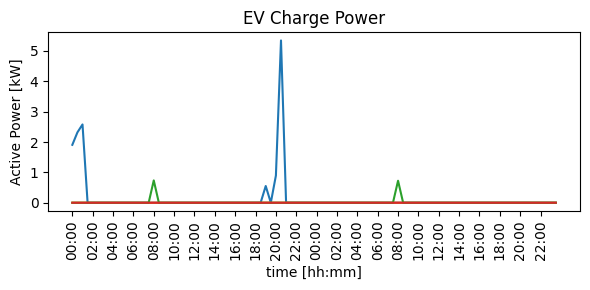

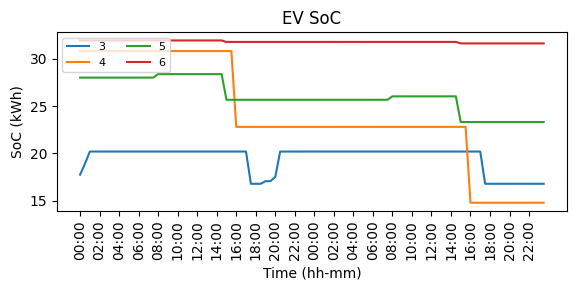

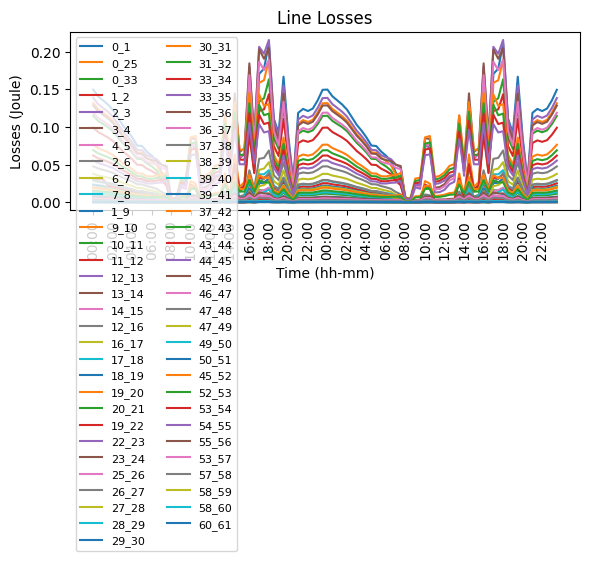

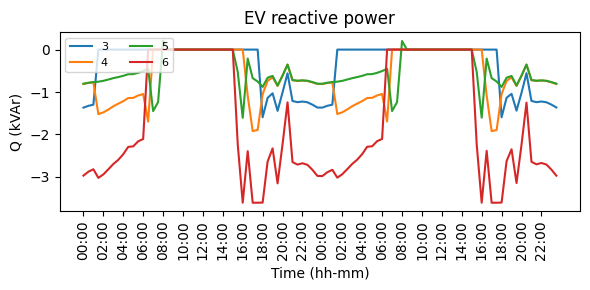

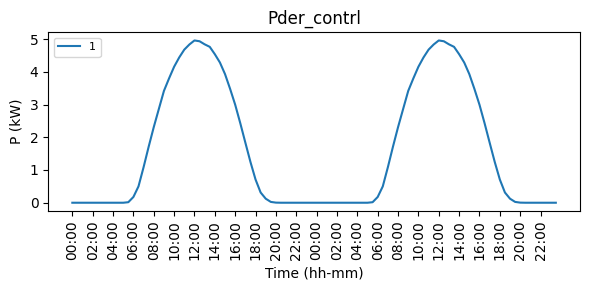

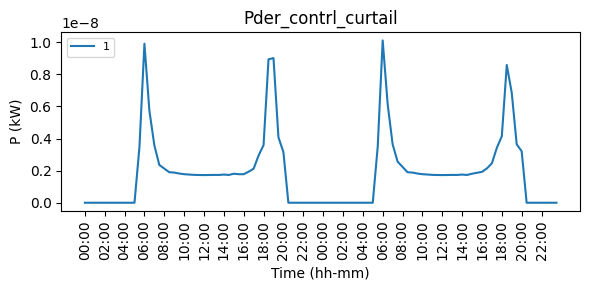

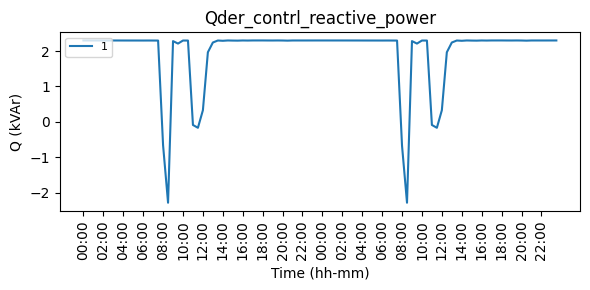

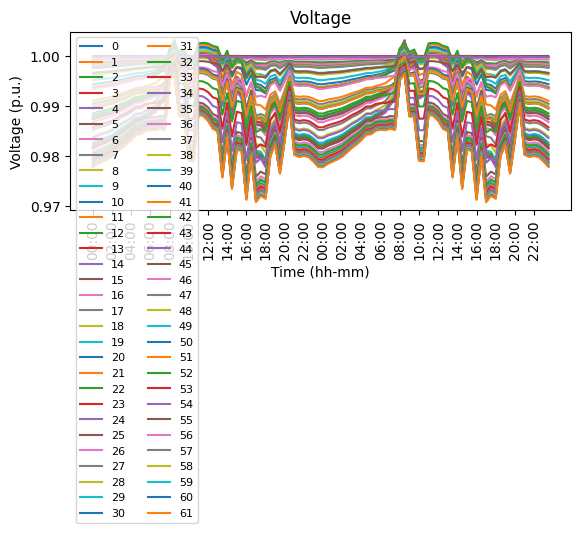

In [95]:
manager.plot_fun.result_df_plot(manager.results.pEVch*manager.anc_Vars.S_Base*1000,"EV Charge Power", "time [hh:mm]" ,"Active Power [kW]")
manager.plot_fun.result_df_plot(manager.results.EVsoc*manager.anc_Vars.S_Base*1000,"EV SoC", "Time (hh-mm)" ,"SoC (kWh)",label="Yes")
manager.plot_fun.result_df_plot(manager.results.Line_losses*manager.anc_Vars.I_base*1000,"Line Losses", "Time (hh-mm)" ,"Losses (Joule)",label="Yes")
manager.plot_fun.result_df_plot(manager.results.qEV*manager.anc_Vars.S_Base*1000,"EV reactive power", "Time (hh-mm)" ,"Q (kVAr)",label="Yes")
manager.plot_fun.result_df_plot(manager.results.pder_contr*manager.anc_Vars.S_Base*1000,"Pder_contrl", "Time (hh-mm)" ,"P (kW)",label="Yes")
manager.plot_fun.result_df_plot(manager.results.pder_curtail_contr*manager.anc_Vars.S_Base*1000,"Pder_contrl_curtail", "Time (hh-mm)" ,"P (kW)",label="Yes")
manager.plot_fun.result_df_plot(manager.results.qder_contr*manager.anc_Vars.S_Base*1000,"Qder_contrl_reactive_power", "Time (hh-mm)" ,"Q (kVAr)",label="Yes")
manager.plot_fun.result_df_plot(np.sqrt(manager.results.v),"Voltage", "Time (hh-mm)" ,"Voltage (p.u.)", label="Yes")


In [38]:
from pyomo.environ import value

for idx in manager.model.current_equal_pf:
    c = manager.model.current_equal_pf[idx]
    lhs = value(c.body)
    rhs = value(c.upper) if c.has_ub() else None 
    print(f"LHS = {lhs:.8e}    RHS = {rhs:.8e}    Violation = {abs(lhs - rhs):.2e}")


LHS = -4.11039282e-05    RHS = 0.00000000e+00    Violation = 4.11e-05
LHS = -4.15032207e-05    RHS = 0.00000000e+00    Violation = 4.15e-05
LHS = -4.17452260e-05    RHS = 0.00000000e+00    Violation = 4.17e-05
LHS = -4.60892196e-05    RHS = 0.00000000e+00    Violation = 4.61e-05
LHS = -4.79741127e-05    RHS = 0.00000000e+00    Violation = 4.80e-05
LHS = -5.18677205e-05    RHS = 0.00000000e+00    Violation = 5.19e-05
LHS = -5.46190941e-05    RHS = 0.00000000e+00    Violation = 5.46e-05
LHS = -5.68808742e-05    RHS = 0.00000000e+00    Violation = 5.69e-05
LHS = -5.79306734e-05    RHS = 0.00000000e+00    Violation = 5.79e-05
LHS = -5.56462269e-05    RHS = 0.00000000e+00    Violation = 5.56e-05
LHS = -5.54064677e-05    RHS = 0.00000000e+00    Violation = 5.54e-05
LHS = -5.26456741e-05    RHS = 0.00000000e+00    Violation = 5.26e-05
LHS = -5.15652633e-05    RHS = 0.00000000e+00    Violation = 5.16e-05
LHS = -5.04354251e-05    RHS = 0.00000000e+00    Violation = 5.04e-05
LHS = -4.77893739e-0